In [5]:
print("all ok")

all ok


In [6]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: c:\Users\Sunny\automated-research-report-generation


In [7]:
from research_and_analyst.utils.model_loader import ModelLoader

In [8]:
model_loader = ModelLoader()

{"timestamp": "2025-10-12T09:00:58.292294Z", "level": "info", "event": "OPENAI_API_KEY loaded from environment"}
{"timestamp": "2025-10-12T09:00:58.293798Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-10-12T09:00:58.294803Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-10-12T09:00:58.295804Z", "level": "warning", "event": "ASTRA_DB_API_ENDPOINT is missing from environment"}
{"timestamp": "2025-10-12T09:00:58.296803Z", "level": "warning", "event": "ASTRA_DB_APPLICATION_TOKEN is missing from environment"}
{"timestamp": "2025-10-12T09:00:58.297805Z", "level": "warning", "event": "ASTRA_DB_KEYSPACE is missing from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-10-12T09:00:58.300802Z", "level": "info", "event": "YAML config loaded"}


In [9]:
llm=model_loader.load_llm()

{"provider": "openai", "model": "gpt-4o", "timestamp": "2025-10-12T09:01:00.419019Z", "level": "info", "event": "Loading LLM"}


In [10]:
llm.invoke("hi").content

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Hello! How can I assist you today?'

In [11]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [12]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver

#health

Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
        ),

Analyst(
    name="Dr. Arun Verma",
    role="Ethics Researcher",
    affiliation="WHO",
    description="Explores ethical implications of AI in diagnostics."
),
Analyst(
    name="Ms. Priya Sharma",
    role="Policy Analyst",
    affiliation="Ministry of Health",
    description="Investigates AI policy and compliance frameworks."
)

In [13]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [10]:
Analyst(
    name="sunny savita",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

Analyst(name='sunny savita', role='genai eng', affiliation='AI Research LAB', description='I am genai developer as well as mentor')

In [11]:
analyst = Analyst(
    name="sunny savita",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

In [12]:
analyst.name

'sunny savita'

In [13]:
analyst.role

'genai eng'

In [14]:
analyst.affiliation

'AI Research LAB'

In [15]:
print(analyst.persona)

Name: sunny savita
Role: genai eng
Affiliation: AI Research LAB
Description: I am genai developer as well as mentor



In [14]:
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [15]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    

In [18]:
GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'give the real info'}

In [19]:
Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
    ),

(Analyst(name='Dr. Neha Patel', role='Medical Data Scientist', affiliation='Stanford Medicine', description='Focuses on predictive models for patient outcomes.'),)

In [16]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [21]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']

In [17]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}
    

In [23]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Emily Chen', role='Public Health Analyst', affiliation='World Health Organization', description='Dr. Emily Chen focuses on global health trends, particularly the impact of pandemics on public health systems. Her primary concern is understanding how health policies can be optimized to improve resilience against future health crises. She is motivated by the need to ensure equitable access to healthcare resources worldwide.'),
  Analyst(name='Dr. Raj Patel', role='Healthcare Technology Analyst', affiliation='MIT Media Lab', description='Dr. Raj Patel specializes in the intersection of technology and healthcare, exploring how innovations like AI and telemedicine can transform patient care. His focus is on evaluating the effectiveness and ethical implications of new technologies in healthcare delivery. He is driven by the potential to enhance healthcare accessibility and efficiency through technological advancements.')]}

In [18]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [19]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END


In [ ]:
# def should_continue(state):
#     """ Return the next node to execute """
#     human_analyst_feedback = state.get("human_analyst_feedback",None)
#     if human_analyst_feedback:
#         return "create_analyst"

In [20]:
from IPython.display import Image, display

## First Workflow

In [21]:
builder = StateGraph(GenerateAnalystsState)

In [22]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)

In [23]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])

In [24]:
memory = MemorySaver()

In [25]:
graph = builder.compile(interrupt_before= ["human_feedback"],checkpointer= memory)

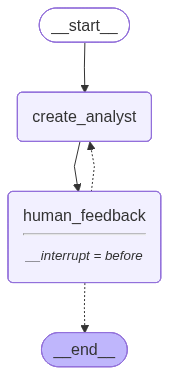

In [26]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [27]:
topic = "the benefits of adopting Langgraph as an agent framework"

In [28]:
max_analysts = 4

In [29]:
thread =  {"configurable":{"thread_id":1}}

In [30]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  
            
        

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Affiliation: Institute of Advanced AI Systems
Role: AI Framework Researcher
Description: Dr. Chen focuses on the comparative analysis of AI frameworks, with a particular interest in how Langgraph enhances agent-based systems. Her research is driven by the need to understand the scalability and adaptability of AI frameworks in dynamic environments.
--------------------------------------------------
Name: Raj Patel
Affiliation: Tech Innovators Inc.
Role: Software Development Lead
Description: Raj is a software development lead who is interested in the practical implementation of Langgraph in real-world applications. His primary concern is how Langgraph can streamline development processes and improve the efficiency of software teams.
--------------------------------------------------
Name: Lisa Gomez
Affiliation: Global AI Ethics Consortium
Role: AI Ethics Specialist
Description: Lisa examines the ethical implications of adopting new AI frameworks like Langgraph. She

In [31]:
state = graph.get_state(thread)

In [32]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Dr. Emily Chen', role='AI Framework Researcher', affiliation='Institute of Advanced AI Systems', description='Dr. Chen focuses on the comparative analysis of AI frameworks, with a particular interest in how Langgraph enhances agent-based systems. Her research is driven by the need to understand the scalability and adaptability of AI frameworks in dynamic environments.'), Analyst(name='Raj Patel', role='Software Development Lead', affiliation='Tech Innovators Inc.', description='Raj is a software development lead who is interested in the practical implementation of Langgraph in real-world applications. His primary concern is how Langgraph can streamline development processes and improve the efficiency of software teams.'), Analyst(name='Lisa Gomez', role='AI Ethics Specialist', affiliation='Global AI Ethics Consortium', description='Lisa examines the e

In [33]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'analysts': [Analyst(name='Dr. Emily Chen', role='AI Framework Researcher', affiliation='Institute of Advanced AI Systems', description='Dr. Chen focuses on the comparative analysis of AI frameworks, with a particular interest in how Langgraph enhances agent-based systems. Her research is driven by the need to understand the scalability and adaptability of AI frameworks in dynamic environments.'),
  Analyst(name='Raj Patel', role='Software Development Lead', affiliation='Tech Innovators Inc.', description='Raj is a software development lead who is interested in the practical implementation of Langgraph in real-world applications. His primary concern is how Langgraph can streamline development processes and improve the efficiency of software teams.'),
  Analyst(name='Lisa Gomez', role='AI Ethics Specialist', affiliation='Global AI Ethics Consortium', description='Lisa examines the ethical implicat

In [34]:
state.next

('human_feedback',)

In [90]:
# memory.storage

In [35]:
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0a74a1-28f5-6c97-bfff-e5f5ff31a375': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-12T09:01:42.928911+00:00\xa2id\xd9$1f0a74a1-28f5-6c97-bfff-e5f5ff31a375\xb0channel_versions\x81\xa9__start__\xd9300000000000000000000000000000001.0.6273214214912726\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0a74a1-28f8-63cf-8000-10db174e3f62': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-12T09:01:42.929915+00:00\xa2id\xd9$1f0a74a1-28f8-63cf-8000-10db174e3f62\xb0channel_versions\x84\xa9__start__\xd9400000000000000000000000000000002.0.18701145666610763\xa5topic\xd9400000000000000000000000000000002.0.18701145666610763\xacmax_analysts\xd9400000000000000000000000000000002.0.18701145666610763\xb8branch:to:create_analyst\xd9400000000000000000000000000000002.0.18701145666610763\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start_

In [91]:
# import msgpack

# for thread_id, ns_dict in memory.storage.items():
#     print(f"\n Thread ID: {thread_id}")
    
#     # ns_dict = defaultdict(dict, {'': {...}})
#     for ns, ckpts in ns_dict.items():
#         print(f"  Namespace: '{ns}'")
        
#         # ckpts = dict of {checkpoint_id: (packed_values, packed_metadata, parent_id)}
#         for ckpt_id, (packed_values, packed_metadata, parent_id) in ckpts.items():
#             print(f"    Checkpoint ID: {ckpt_id}")
            
#             # Decode msgpack binary
#             values = msgpack.unpackb(packed_values[1], raw=False)
#             meta = msgpack.unpackb(packed_metadata[1], raw=False)
            
#             print(f"    Values keys: {list(values.keys())}")
#             print(f"    Parent ID: {parent_id}")
#             print(f"    Metadata: {meta}")
#             print("-" * 80)


In [36]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a74a1-5575-68b7-8001-67db9dba3e07'}}

In [37]:
graph.update_state(thread,
                   {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"},as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a74a2-7444-6fdf-8002-859c4656c40e'}}

In [38]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Chen
Affiliation: Institute of Advanced AI Systems
Role: AI Framework Researcher
Description: Dr. Chen focuses on the comparative analysis of AI frameworks, with a particular interest in how Langgraph enhances agent-based systems. Her research is driven by the need to understand the scalability and adaptability of AI frameworks in dynamic environments.
--------------------------------------------------
Name: Raj Patel
Affiliation: Tech Innovators Inc.
Role: Software Development Lead
Description: Raj is a software development lead who is interested in the practical implementation of Langgraph in real-world applications. His primary concern is how Langgraph can streamline development processes and improve the efficiency of software teams.
--------------------------------------------------
Name: Lisa Gomez
Affiliation: Global AI Ethics Consortium
Role: AI Ethics Specialist
Description: Lisa examines the ethical implications of adopting new AI frameworks like Langgraph. She

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Sophia Tran
Affiliation: Tech Innovators Network
Role: Startup Ecosystem Analyst
Description: Sophia focuses on how emerging technologies like Langgraph can be leveraged by startups to gain competitive advantages. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance product development cycles for new companies.
--------------------------------------------------
Name: Raj Patel
Affiliation: Global Enterprise Solutions
Role: Enterprise Application Specialist
Description: Raj examines the integration of Langgraph within large-scale enterprise applications. His focus is on how Langgraph can improve scalability, enhance data processing capabilities, and support complex workflows in established businesses.
--------------------------------------------------
Name: Elena Garcia
Affiliation: Institute of Advanced AI Studies
Role: AI Framework Researcher
Description: Elena's research delves into the technical benefits of adopting Langgraph as 

In [39]:
state = graph.get_state(thread)

In [40]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on how emerging technologies like Langgraph can be leveraged by startups to gain competitive advantages. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance product development cycles for new companies.'), Analyst(name='Raj Patel', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description='Raj examines the integration of Langgraph within large-scale enterprise applications. His focus is on how Langgraph can improve scalability, enhance data processing capabilities, and support complex workflows in established businesses.'), Analyst(nam

In [41]:
state.next

('human_feedback',)

In [42]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application',
 'analysts': [Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on how emerging technologies like Langgraph can be leveraged by startups to gain competitive advantages. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance product development cycles for new companies.'),
  Analyst(name='Raj Patel', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description='Raj examines the integration of Langgraph within large-scale enterprise applications. His focus is on how Langgraph can improve scalability, enhance data processing capabilities, and support complex workflows in established businesses.'),
  Analyst(name='Elena Garci

In [99]:
# import msgpack

# def get_all_checkpoints(memory, thread_id="1"):
#     """Return all checkpoints in chronological order for a thread."""
#     checkpoints = []
#     ns_dict = memory.storage.get(thread_id, {})
#     if "" not in ns_dict:
#         return []

#     for ckpt_id, (packed_values, packed_meta, parent_id) in ns_dict[""].items():
#         values = msgpack.unpackb(packed_values[1], raw=False)
#         meta = msgpack.unpackb(packed_meta[1], raw=False)
#         checkpoints.append({
#             "id": ckpt_id,
#             "parent": parent_id,
#             "topic": values.get("topic"),
#             "feedback": values.get("human_analyst_feedback"),
#             "analyst_count": len(values.get("analysts", [])),
#             "analysts": [a.model_dump() for a in values.get("analysts", [])],
#             "step": meta.get("step"),
#             "created_at": values.get("ts", None)
#         })
#     return checkpoints

# # Fetch all
# history = get_all_checkpoints(memory)

# # Sort by step (to get chronological order)
# history = sorted(history, key=lambda x: (x["step"] or 0))

# # Display neatly
# for h in history:
#     print(f"\nSTEP {h['step']} | CHECKPOINT {h['id']}")
#     print(f"Parent: {h['parent']}")
#     print(f"Topic: {h['topic']}")
#     print(f"Feedback: {h['feedback']}")
#     print(f"Analysts generated: {h['analyst_count']}")
#     print("-"*100)


In [43]:
# If we are satisfied, then we simply supply no feedback
further_feedack = ""

In [44]:
# 1) Get the latest state (you're paused at 'human_feedback')
state = graph.get_state(thread)

# 2) Use the exact config from that state (it already has thread_id, checkpoint_ns, checkpoint_id)
cfg = state.config

In [45]:
# 3) Update feedback at the 'human_feedback' node
#    Tip: if your TypedDict says `human_analyst_feedback: str`, prefer "" (empty string) over None
graph.update_state(cfg, {"human_analyst_feedback": ""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a74a3-b889-62d2-8006-f0abb8583af5'}}

In [46]:
# 4) Verify it moved to END
final_state = graph.get_state(thread)
print(final_state.next)  # should be (END,)


()


In [47]:
analysts = final_state.values.get('analysts')

In [48]:
analysts

[Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on how emerging technologies like Langgraph can be leveraged by startups to gain competitive advantages. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance product development cycles for new companies.'),
 Analyst(name='Raj Patel', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description='Raj examines the integration of Langgraph within large-scale enterprise applications. His focus is on how Langgraph can improve scalability, enhance data processing capabilities, and support complex workflows in established businesses.'),
 Analyst(name='Elena Garcia', role='AI Framework Researcher', affiliation='Institute of Advanced AI Studies', description="Elena's research delves into the technical benefits of adopting Langgraph as an agent framework. She is interested in its archit

In [49]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Sophia Tran
Affiliation: Tech Innovators Network
Role: Startup Ecosystem Analyst
Description: Sophia focuses on how emerging technologies like Langgraph can be leveraged by startups to gain competitive advantages. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance product development cycles for new companies.
--------------------------------------------------
Name: Raj Patel
Affiliation: Global Enterprise Solutions
Role: Enterprise Application Specialist
Description: Raj examines the integration of Langgraph within large-scale enterprise applications. His focus is on how Langgraph can improve scalability, enhance data processing capabilities, and support complex workflows in established businesses.
--------------------------------------------------
Name: Elena Garcia
Affiliation: Institute of Advanced AI Studies
Role: AI Framework Researcher
Description: Elena's research delves into the technical benefits of adopting Langgraph as 

In [ ]:
"The benefits of adopting LangGraph as an agent framework"

In [50]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


Either you can use Google Serper API or use duckduckgo

In [58]:
from langchain_community.document_loaders import WikipediaLoader
docs = WikipediaLoader(query="The benefits of adopting AWS Cloud").load()
print(docs[0].page_content[:500])

Cloud computing is "a paradigm for enabling network access to a scalable and elastic pool of shareable physical or virtual resources with self-service provisioning and administration on-demand," according to ISO. It is commonly referred to as "the cloud".


== Characteristics ==
In 2011, the National Institute of Standards and Technology (NIST) identified five "essential characteristics" for cloud systems. Below are the exact definitions according to NIST:

On-demand self-service: "A consumer ca


In [ ]:
from langchain_community.document_loaders import WikipediaLoader
docs = WikipediaLoader(query="The benefits of adopting AWS Cloud").load()
print(docs)

[Document(metadata={'title': 'Cloud computing', 'summary': 'Cloud computing is "a paradigm for enabling network access to a scalable and elastic pool of shareable physical or virtual resources with self-service provisioning and administration on-demand," according to ISO. It is commonly referred to as "the cloud".\n\n', 'source': 'https://en.wikipedia.org/wiki/Cloud_computing'}, page_content='Cloud computing is "a paradigm for enabling network access to a scalable and elastic pool of shareable physical or virtual resources with self-service provisioning and administration on-demand," according to ISO. It is commonly referred to as "the cloud".\n\n\n== Characteristics ==\nIn 2011, the National Institute of Standards and Technology (NIST) identified five "essential characteristics" for cloud systems. Below are the exact definitions according to NIST:\n\nOn-demand self-service: "A consumer can unilaterally provision computing capabilities, such as server time and network storage, as neede

In [60]:
from langchain_community.document_loaders import WikipediaLoader
docs = WikipediaLoader(query="AWS").load()
print(docs[0].page_content[:500])

c:\Users\Sunny\automated-research-report-generation\.venv\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\Sunny\automated-research-report-generation\.venv\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Amazon Web Services, Inc. (AWS) is a subsidiary of Amazon that provides on-demand cloud computing platforms and APIs to individuals, companies, and governments, on a metered, pay-as-you-go basis. Clients will often use this in combination with autoscaling (a process that allows a client to use more computing in times of high application usage, and then scale down to reduce costs when there is less traffic). These cloud computing web services provide various services related to networking, comput


In [54]:
from langchain_community.utilities import WikipediaAPIWrapper

In [56]:
wiki = WikipediaAPIWrapper(doc_content_chars_max=4000)
docs = wiki.run("The benefits of adopting LangGraph as an agentic framework")
print(docs)

Page: Semantic Web
Summary: The Semantic Web, sometimes known as Web 3.0, is an extension of the World Wide Web through standards set by the World Wide Web Consortium (W3C). The goal of the Semantic Web is to make Internet data machine-readable.
To enable the encoding of semantics with the data, technologies such as Resource Description Framework (RDF) and Web Ontology Language (OWL) are used. These technologies are used to formally represent metadata. For example, ontology can describe concepts, relationships between entities, and categories of things. These embedded semantics offer significant advantages such as reasoning over data and operating with heterogeneous data sources.
These standards promote common data formats and exchange protocols on the Web, fundamentally the RDF. According to the W3C, "The Semantic Web provides a common framework that allows data to be shared and reused across application, enterprise, and community boundaries." The Semantic Web is therefore regarded as

## Second Workflow

In [61]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [62]:
from dotenv import load_dotenv
load_dotenv()
import os
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [63]:
tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)

C:\Users\Sunny\AppData\Local\Temp\ipykernel_30312\1029971610.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)


In [64]:
tavily_search.invoke("langgraph")

[{'title': 'What is LangGraph? - GeeksforGeeks',
  'url': 'https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/',
  'content': 'LangGraph is an open-source framework built by LangChain that streamlines the creation and management of AI agent workflows. At its core, LangGraph combines large language models (LLMs) with graph-based architectures allowing developers to map, organize and optimize how AI agents interact and make decisions.',
  'score': 0.9294982},
 {'title': 'What is LangGraph? - Analytics Vidhya',
  'url': 'https://www.analyticsvidhya.com/blog/2024/07/langgraph-revolutionizing-ai-agent/',
  'content': 'To sum up, LangGraph is a major advancement in the development of AI agents. It enables developers to push the limits of what’s possible with AI agents by eliminating the shortcomings of earlier systems and offering a flexible, graph-based framework for agent construction and execution. LangGraph is positioned to influence the direction of artificial intelligence

In [65]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 

In [66]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [67]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [174]:
print(analyst.persona)

Name: Michael Chen
Role: Business Strategy Consultant
Affiliation: FutureTech Consulting
Description: Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.



In [175]:
question_instructions.format(goals = analyst.persona)

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Michael Chen\nRole: Business Strategy Consultant\nAffiliation: FutureTech Consulting\nDescription: Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with your understanding, complete the interview with: "Thank you

In [ ]:
'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Michael Chen\nRole: Business Strategy Consultant\nAffiliation: FutureTech Consulting\nDescription: Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"\n\nRemember to stay in character throughout your response, reflecting the persona and goals provided to you.'

In [68]:
def generation_question(state:InterviewState):
    """Node to generate the questions"""
    
    #get state
    analyst = state["analyst"]
    messages = state["messages"]
    
    #generate the question
    system_message = question_instructions.format(goals = analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
    
    #returen the question through state
    return {"messages":[question]}

In [180]:
analyst

Analyst(name='Michael Chen', role='Business Strategy Consultant', affiliation='FutureTech Consulting', description='Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.')

In [69]:
class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

In [193]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],"messages":[HumanMessage(content="hi do the proper search according to the experties")]}

In [194]:
state

{'max_num_turns': 2,
 'context': [],
 'analyst': Analyst(name='Michael Chen', role='Business Strategy Consultant', affiliation='FutureTech Consulting', description='Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.'),
 'interview': '',
 'section': [],
 'messages': [HumanMessage(content='hi do the proper search according to the experties', additional_kwargs={}, response_metadata={})]}

In [196]:
result = generation_question(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [202]:
result

{'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reaso

In [200]:
print(result["messages"][0].content)

Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. 

To start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?


In [70]:
from langchain_core.messages import get_buffer_string

In [71]:
# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [72]:
def search_web(state:InterviewState):
    """
    Retrieve data from the web
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    search_query = structure_llm.invoke([search_instructions]+state["messages"])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [208]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [209]:
result = search_web(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [213]:
print(result["context"][0])

<Document href="https://www.scalablepath.com/machine-learning/langgraph"/>
In fact, the rapid adoption of AI agents by companies indicates a strategic shift. Early movers are using AI agents to handle tasks that were once bottlenecks, gaining an edge in customer responsiveness, data analysis, and innovation capacity. Using a framework like LangGraph ensures these AI initiatives are scalable and maintainable, so one is building a long-term strategic asset, not just a demo or one-off script.

### Practical Gains: Save Time and Money While Reducing Errors [...] Another advantage of the LangGraph approach is that one can precisely control when and how agents interact. The graph’s edges and nodes act like a playbook for the team of agents. One can have phases in the workflow where agents work in parallel, and then points where the workflow pauses and awaits a decision or input. [...] This approach has strong parallels to how human teams work, and indeed some benefits are the same: specializ

In [73]:
def search_wikipedia(state:InterviewState):
    """
    Retrieve data from wiki
    """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    print("*******************************")
    print(search_query)
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 
    

In [225]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [226]:
result = search_wikipedia(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph framework benefits for business innovation and digital transformation'


In [240]:
search_docs = WikipediaLoader(query='Langgraph framework benefits',load_all_available_meta=True).load()

In [241]:
search_docs

[]

In [227]:
result

{'context': ['']}

In [74]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [75]:
def generate_answer(state:InterviewState):
   
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}
    

how many analyst we were doing to be create:
4

max_trun:2

means if atleast 2 expert are giving ans then we can save the result.

In [76]:
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

In [77]:
def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

In [78]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [79]:
def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}


In [80]:
interview_builder = StateGraph(InterviewState)

In [81]:
interview_builder.add_node("ask_question",generation_question)
interview_builder.add_node("search_web",search_web)
interview_builder.add_node("search_wikipedia",search_wikipedia)
interview_builder.add_node("generate_answer",generate_answer)
interview_builder.add_node("save_interview",save_interview)
interview_builder.add_node("write_section",write_section)

In [82]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web","generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                           route_messages,
                           ["ask_question",
                            "save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)

In [83]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")


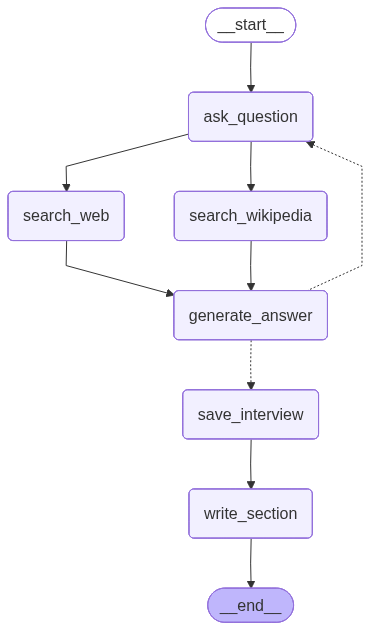

In [84]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [85]:
analyst

Analyst(name='Michael Chen', role='Business Strategy Consultant', affiliation='FutureTech Consulting', description='Michael advises companies on strategic adoption of new technologies. He focuses on the business implications of integrating Langgraph, including potential ROI, market positioning, and long-term benefits for companies looking to innovate and stay ahead of the competition.')

In [86]:
analyst.persona

'Name: Michael Chen\nRole: Business Strategy Consultant\nAffiliation: FutureTech Consulting\nDescription: Michael advises companies on strategic adoption of new technologies. He focuses on the business implications of integrating Langgraph, including potential ROI, market positioning, and long-term benefits for companies looking to innovate and stay ahead of the competition.\n'

In [87]:
thread = {"configurable": {"thread_id": "1"}}

In [88]:
from IPython.display import Markdown

In [89]:
messages = [HumanMessage("So you said you were writing an article on Langchain?")]

In [90]:
interview = interview_graph.invoke({"analyst": analyst, "messages": messages, "max_num_turns": 2}, thread)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph impact on company ROI strategic adoption'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph integration success stories ROI market positioning competitive advantage'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [91]:
Markdown(interview['sections'][0])

## Strategic Integration of LangGraph: Unlocking Business Potential

### Summary

In the rapidly evolving landscape of AI technologies, LangGraph has emerged as a pivotal framework for enterprises aiming to enhance their strategic positioning and achieve significant returns on investment (ROI). As companies increasingly adopt AI agent frameworks like LangGraph, they are witnessing transformative impacts on productivity, cost efficiency, and market competitiveness. This report delves into the business implications of integrating LangGraph, highlighting its potential to drive innovation and maintain a competitive edge.

LangGraph stands out for its structured reasoning capabilities, which allow enterprises to develop sophisticated, production-grade AI systems capable of handling complex real-world requirements. This framework not only supports efficient resource utilization but also offers scalable solutions that can lead to better ROI for large-scale deployments [1]. The strategic choice between LangGraph and other frameworks like LangChain is crucial, as it influences an organization's AI development trajectory and long-term success [2].

One of the most compelling aspects of LangGraph is its ability to enhance developer productivity and streamline operations. By automating complex processes such as invoice reconciliation and security alert triage, companies like Cognosys and Adept have reported over 60% reductions in manual labor [3]. This efficiency translates into substantial cost savings and improved customer loyalty, contributing to a projected 150% ROI over two years for some enterprises [1].

Moreover, LangGraph's architecture facilitates complete state tracking and checkpointing, providing natural audit trails that simplify compliance reporting. This feature is particularly beneficial for compliance-sensitive industries, where maintaining audit logs can be challenging [2]. The framework's ability to integrate seamlessly with existing setups and reduce redundant work further enhances its appeal to engineering leaders seeking to unlock collective intelligence from the best models without vendor lock-in [4].

The strategic integration of LangGraph also involves a phased approach to measuring ROI. Enterprises are advised to start with low-risk pilots tied to clear business outcomes, build trust and momentum by socializing wins, and scale intentionally by integrating pilots into processes and platforms [5]. This methodical approach ensures that AI adoption not only unlocks ROI but also aligns with long-term business objectives.

In conclusion, LangGraph offers a robust framework for enterprises looking to innovate and stay ahead of the competition. Its structured approach to AI development, combined with its scalability and compliance benefits, makes it a strategic asset for companies aiming to maximize their ROI and achieve sustainable growth.

### Sources
[1] https://sparkco.ai/blog/langgraph-vs-crewai-vs-autogen-2025-production-showdown  
[2] https://thirdeyedata.ai/a-comparative-study-between-langgraph-and-langchain-for-enterprise-ai-development/  
[3] https://medium.com/write-your-world/how-agentic-ai-frameworks-work-under-the-hood-langgraph-autogen-crewai-3aad57b8cc12  
[4] https://www.linkedin.com/posts/towards-data-science_how-to-build-an-ai-budget-planning-optimizer-activity-7371606983545860097-JMiY  
[5] https://www.linkedin.com/posts/damianleon_ai-ceo-coo-activity-7355231116087238657-3Pt7  

## third Workflow

In [ ]:
from typing_extensions import TypedDict
from typing import List, Annotated
import operator
class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report
    
# class InterviewState(MessagesState):
#     max_num_turns: int # Number turns of conversation
#     context: Annotated[list, operator.add] # Source docs
#     analyst: Analyst # Analyst asking questions
#     interview: str # Interview transcript
#     sections: list # Final key we duplicate in outer state for Send() API

In [100]:
from langgraph.types import Send

In [101]:
def initiate_all_interviews(state:ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """ 
    
    #check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"
    
    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                        "messages": [HumanMessage(
                                            content=f"So you said you were writing an article on {topic}?"
                                        )
                                                ]}) for analyst in state["analysts"]]


In [ ]:
# def write_report(state:ResearchGraphState):
#     """_summary_

#     Args:
#         state (ResearchGraphState): _description_
#     """
#     pass

In [102]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [103]:
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

In [104]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

In [105]:
def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

In [106]:
def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

In [108]:
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

In [113]:
# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)


In [110]:
memory = MemorySaver()

In [111]:
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

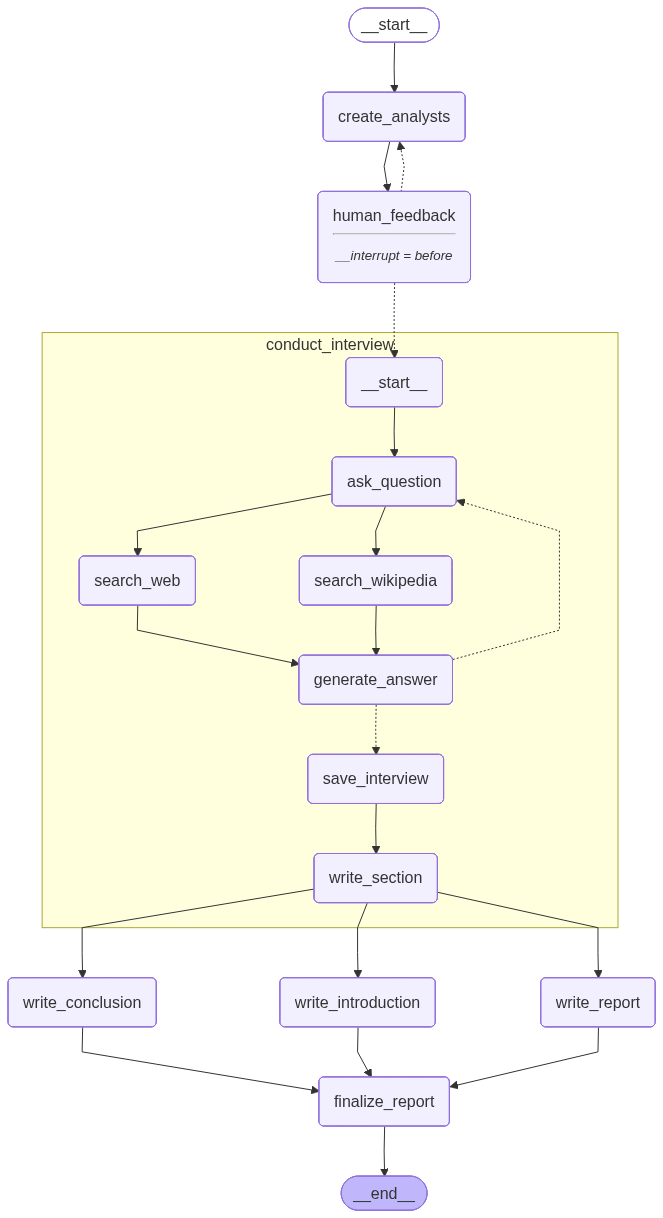

In [112]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [114]:
max_analysts = 3

In [127]:
topic = "How can generative help us to play the cricket?"

In [ ]:
topic = "How can generative AI accelerate drug discovery?"

In [128]:
thread = {"configurable": {"thread_id": "1"}}

In [129]:
# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Chen
Affiliation: Global Pharma Innovations
Role: Pharmaceutical Research Scientist
Description: Dr. Chen focuses on the integration of generative AI in the early stages of drug discovery. She is particularly interested in how AI can identify novel compounds and predict their interactions with biological targets, thereby reducing the time and cost associated with traditional drug discovery methods. Her concerns include ensuring the accuracy and reliability of AI predictions and the ethical implications of AI-driven research.
--------------------------------------------------
Name: Dr. Raj Patel
Affiliation: Innovative Clinical Solutions
Role: Clinical Trials Specialist
Description: Dr. Patel is dedicated to exploring the future uses of generative AI in clinical trials. He examines how AI can optimize trial design, patient recruitment, and data analysis, potentially leading to more efficient and effective trials. His focus is on overcoming regulatory challenges and ensur

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Sarah Patel
Affiliation: University of Melbourne
Role: AI and Sports Technology Researcher
Description: Dr. Patel focuses on the integration of AI technologies in sports, particularly how generative AI can enhance player performance and strategy in cricket. She is interested in how AI can simulate various game scenarios to help players improve their decision-making skills and adapt to different playing conditions.
--------------------------------------------------
Name: Michael Thompson
Affiliation: International Cricket Council (ICC)
Role: Cricket Coach and Analyst
Description: Michael is a seasoned cricket coach who explores the practical applications of generative AI in coaching. He is particularly concerned with how AI can be used to analyze player techniques and provide personalized feedback to improve skills. His motive is to leverage AI to make training more efficient and tailored to individual player needs.
--------------------------------------------------
Name: Dr. 

In [130]:
graph.update_state(thread, {"human_analyst_feedback":"along with the genetive ai in future tell me the future of indian team"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a7596-ddd0-6165-800d-858b068fe47e'}}

In [131]:
# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Sarah Patel
Affiliation: University of Melbourne
Role: AI and Sports Technology Researcher
Description: Dr. Patel focuses on the integration of AI technologies in sports, particularly how generative AI can enhance player performance and strategy in cricket. She is interested in how AI can simulate various game scenarios to help players improve their decision-making skills and adapt to different playing conditions.
--------------------------------------------------
Name: Michael Thompson
Affiliation: International Cricket Council (ICC)
Role: Cricket Coach and Analyst
Description: Michael is a seasoned cricket coach who explores the practical applications of generative AI in coaching. He is particularly concerned with how AI can be used to analyze player techniques and provide personalized feedback to improve skills. His motive is to leverage AI to make training more efficient and tailored to individual player needs.
--------------------------------------------------
Name: Dr. 

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Anjali Mehta
Affiliation: Indian Institute of Technology, Delhi
Role: AI and Sports Integration Specialist
Description: Dr. Mehta focuses on the integration of generative AI technologies in sports, particularly cricket. Her research explores how AI can enhance player performance, strategy development, and fan engagement. She is particularly interested in how AI can predict game outcomes and assist in training regimens.
--------------------------------------------------
Name: Rajesh Kumar
Affiliation: ESPNcricinfo
Role: Cricket Analyst and Historian
Description: Rajesh Kumar is a seasoned cricket analyst with a deep understanding of the game's history and evolution. He examines how generative AI can be used to simulate historical matches, analyze player statistics, and provide insights into the future performance of teams, including the Indian cricket team.
--------------------------------------------------
Name: Priya Singh
Affiliation: Future of Sports Institute
Role: Sports

In [132]:
graph.update_state(thread, {"human_analyst_feedback":""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a7598-3b35-645c-8011-3556dc39e702'}}

In [133]:
graph.get_state(thread).next

('conduct_interview', 'conduct_interview', 'conduct_interview')

In [134]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='examples of generative AI enhancing player performance in cricket'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='impact of generative AI on team dynamics in cricket'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='generative AI simulate historical cricket matches accuracy'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='generative AI analyzing player statistics predicting future performance Indian cricket team case studies'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='generative AI strategy development cricket teams examples case studies'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='how generative AI enhances fan interaction in cricket'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


--Node--
conduct_interview
--Node--
conduct_interview


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


--Node--
conduct_interview


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


--Node--
write_conclusion


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


--Node--
write_introduction


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


--Node--
write_report
--Node--
finalize_report


In [135]:
from IPython.display import Markdown

In [136]:
final_state = graph.get_state(thread)


In [137]:
report = final_state.values.get('final_report')

In [138]:
Markdown(report)

# Generative AI: Transforming Cricket for the Future

## Introduction

The integration of generative AI into cricket is revolutionizing the sport, offering unprecedented opportunities to enhance player performance, strategy development, and fan engagement. This report explores the multifaceted applications of AI in cricket, from simulating historical matches and predicting future outcomes to optimizing team management and training. AI-driven tools are reshaping strategic decision-making and providing real-time insights, enriching the fan experience. As AI continues to evolve, its impact on cricket is expected to grow, offering exciting possibilities for players, coaches, and fans alike, while expanding the sport's global reach.

---



The integration of generative AI into various fields, including drug discovery, clinical trials, and cricket, is transforming traditional practices by enhancing efficiency, precision, and engagement. In drug discovery, generative AI significantly reduces the time and cost associated with developing new drugs. By leveraging advanced algorithms, AI identifies novel compounds and predicts their interactions with biological targets, as demonstrated by Insilico Medicine's accelerated development of a drug for idiopathic pulmonary fibrosis [1]. Generative models like VAEs and GANs are pivotal in proposing novel molecules and optimizing their properties, as evidenced by NVIDIA's collaboration with Recursion Pharmaceuticals, which screened over 2.8 quadrillion small molecule-target pairs in a week [1][2]. However, the accuracy of AI predictions depends on the quality of training datasets, necessitating rigorous validation and ethical considerations to ensure responsible use [3].

In clinical trials, generative AI optimizes trial design, enhances patient recruitment, and improves data analysis, potentially accelerating the delivery of life-saving treatments. AI can automate documentation and streamline regulatory submissions, reducing costs and speeding up the trial process [3]. However, challenges such as data quality, regulatory compliance, and ethical considerations must be addressed through collaborative and transparent approaches [1][2][4]. Interdisciplinary collaboration is crucial to navigate these challenges and promote the adoption of AI in clinical research [5][6].

The ethical implications of generative AI in drug discovery and clinical trials are significant. The potential for AI to produce misleading information and exacerbate algorithmic bias raises concerns about patient safety and equity [1][3]. Addressing these issues requires strict standards for data security, transparency, and oversight mechanisms to align AI adoption with ethical standards and societal values [1][2].

In cricket, AI is revolutionizing the sport by enhancing player performance, strategy development, and fan engagement. AI-driven simulations allow players to practice against virtual opponents, refining their techniques and preparing for various match scenarios [1][3]. Tools like Hawk-Eye and SportVU provide comprehensive performance data, enabling coaches to tailor training programs and optimize player performance [2]. Predictive analytics tools, such as CricViz, aid in strategic decision-making by analyzing past performance data to predict match outcomes [4]. AI also enhances fan engagement by providing real-time insights and interactive experiences, enriching the viewing experience and fostering a stronger connection between fans and the sport [5].

Generative AI's role in cricket extends to simulating historical matches and predicting future performances, offering strategic advantages and enriching the fan experience [1][2]. AI-driven models using deep learning techniques have shown superior accuracy in predicting match outcomes, incorporating environmental data to enhance predictive capabilities [2]. AI tools also simulate fantasy leagues and generate what-if scenarios, aiding strategic planning and engaging fans [1][3]. The predictive power of AI in forecasting player performance and suitability for specific match conditions is particularly valuable for team management [4].

Globally, AI is increasing cricket's popularity by making the sport more accessible and engaging. AI-driven virtual reality experiences and personalized content delivery are transforming the traditional viewing experience, expanding cricket's global reach [8][9]. As AI continues to evolve, its impact on cricket is expected to grow, offering exciting possibilities for players, coaches, and fans alike.


---

## Conclusion

The integration of generative AI into cricket is revolutionizing the sport by enhancing player performance, strategic decision-making, and fan engagement. AI-driven simulations and predictive analytics are providing players and coaches with unprecedented insights, allowing for more effective training and strategic planning. Tools like Hawk-Eye and CricViz are transforming how matches are analyzed and strategies are developed. Moreover, AI is enriching the fan experience through real-time insights and interactive content, making cricket more engaging and accessible. As AI technologies continue to evolve, their impact on cricket is expected to grow, offering exciting possibilities for players, coaches, and fans alike.

## Sources
[1] https://www.forbes.com/sites/bernardmarr/2024/06/19/how-generative-ai-is-accelerating-drug-discovery/  
[2] https://www.delveinsight.com/blog/generative-ai-drug-discovery-market-impact  
[3] https://pmc.ncbi.nlm.nih.gov/articles/PMC11444559/  
[4] https://dcri.org/news/embracing-generative-ai-clinical-research-and-beyond-opportunities-challenges-and-solutions  
[5] https://www.nature.com/articles/s41746-025-01440-5  
[6] https://www.weforum.org/stories/2024/12/genai-could-transform-clinical-research-trials/  
[7] https://pubmed.ncbi.nlm.nih.gov/39689842/  
[8] https://med.stanford.edu/news/all-news/2024/03/ai-drug-development.html  
[9] https://en.wikipedia.org/wiki/Algorithmic_bias  
[10] https://www.linkedin.com/pulse/transforming-sports-generative-ai-new-era-performance-dr-jagrrit-4onmf  
[11] https://medium.com/@rakrag21/revolutionizing-cricket-the-impact-of-artificial-intelligence-on-the-sport-65fb797c043a  
[12] https://digitaldefynd.com/IQ/ai-use-in-cricket/  
[13] https://www.researchgate.net/publication/367479261_Artificial_Intelligence_and_Data_Analytics_in_Cricket  
[14] https://magnifi.ai/insights/ai-changing-how-cricket-is-played-and-watched  
[15] https://webosmotic.com/blog/ai-in-cricket/  
[16] https://www.irjet.net/archives/V12/i3/IRJET-V12I3179.pdf  
[17] https://sportsmintmedia.com/cricket-australia-live-app-ushers-in-new-era-of-fan-engagement-with-ai-powered-insights/  
[18] https://news.microsoft.com/source/asia/features/from-grassroots-to-elite-how-cricket-australia-is-scoring-better-digital-experiences-with-ai-and-cloud-technology/  
[19] https://tiaki.ai/wp-content/uploads/2025/02/Insights-6B-20250224-Connecting-with-the-.pdf